In [2]:
import os
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import shapely.geometry as geom

## Tabelle mit Haltestellen und Koordinaten der Haltepunkte erstellen

In [3]:
#Import Daten Haltestellen
haltest_temp = pd.read_csv('data/haltestelle.csv', sep=',')
haltest = pd.read_csv('data/HALTESTELLEN.csv', sep=';')
haltep = pd.read_csv('data/haltepunkt.csv')
haltep = haltep[haltep.halt_punkt_ist_aktiv == True]

#GPS-Koordinaten der verschiedenen HaltePUNKTE jeder HalteSTELLE auf einen einzigen zentralen Punkt pro Haltestelle rechnen

haltep = haltep.groupby("halt_id", as_index=True)['GPS_Latitude', 'GPS_Longitude'].mean()

#Join 2 Tabellen Haltestellen auf Key Kurzname und entfernen nicht benötigter Attribute

haltest_komplett = pd.merge(haltest, haltest_temp, how='inner', left_on='Haltestellenkurzname', right_on='halt_kurz', copy=False)
haltest_komplett=haltest_komplett.drop(columns=['Haltestellennummer', 'halt_diva', 'halt_kurz', 'halt_lang', 'halt_ist_aktiv'])

#Tabelle Haltestellen aus GPS-Daten und Haltestellen-ID *beider* Datensätze erstellen: VBZ-Fahrgastzahlen verwendet "Haltestellen_Id" und VBZ-Fahrzeiten verwendet "halt_id" )

haltestellen = pd.merge(haltest_komplett, haltep, how='inner', left_on='halt_id', right_on='halt_id', copy=False)

## Karte vorbereiten TEST

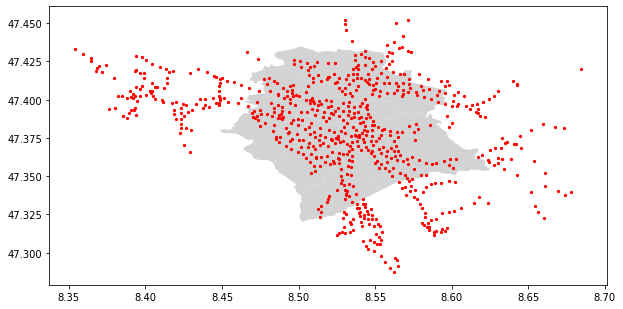

In [4]:
haltestellen_map = gpd.GeoDataFrame(haltestellen, geometry=gpd.points_from_xy(haltestellen.GPS_Longitude, haltestellen.GPS_Latitude))
stadtkreise = gpd.read_file('data/stadtkreise.json')


type(haltestellen_map.geometry[0])
type(stadtkreise.geometry[0])

fig, ax = plt.subplots(1, figsize=(10,10))
base = stadtkreise.plot(ax=ax, color='lightgrey') 
haltestellen_map.plot(ax=base, markersize=5, label = 'plompp', color='red')
#plt.savefig('haltestellen.png',bbox_inches='tight');

## Reisedaten

In [5]:
#Import Tabelle Fahrgastzahlen 
reisende = pd.read_csv('data/reisende.csv', sep=";")

#Tage, die nicht Wochentage (DWV) sind, löschen
droprows = reisende[ reisende['Tage_DWV'] == 0].index

reisende.drop(droprows , inplace=True)

#Fahrgäste "Besetzung" ist als statistischer Wert pro Messung dargestellt. Multiplikation mit diesem Wert, um effektive Zahl zu erhalten
reisende['Besetzung'] = reisende['Besetzung']*reisende['Anzahl_Messungen']

#Weitere nicht benötigte Attribute löschen
reisende = reisende.drop(columns=['Anzahl_Messungen', 'Tage_DTV', 'Tage_DWV', 'Tage_SA', 'Tage_SO', 'Nachtnetz', 'Tage_SA_N', 'Tage_SO_N'])

#Zeit zu vollen Stundenabschnitten zusammenfassen. Faule Lösung: einfach Stunde nehmen. 
reisende['hour'] = reisende['FZ_AB'].str[:2].astype(int)

#GPS-Daten zu den Haltestellen "von" und "bis" in die Fahrgastzahltabelle mergen
reisende_1 = reisende.merge(haltestellen, on='Haltestellen_Id', suffixes=('', ''))
reisende_2 = reisende_1.merge(haltestellen, left_on='Nach_Hst_Id', right_on="Haltestellen_Id", suffixes=('_start', '_ziel'))
reisende = reisende_2.drop(columns=['halt_id_ziel', 'halt_id_start'])

#Aus den GPS-Attributen eine GeoLinie pro Zeile bilden
reisende['lines'] = reisende.apply(lambda x: geom.LineString([(x['GPS_Longitude_start'], x['GPS_Latitude_start']), (x['GPS_Longitude_ziel'], x['GPS_Latitude_ziel'])]), axis=1)

## Karte Linien ausgeben

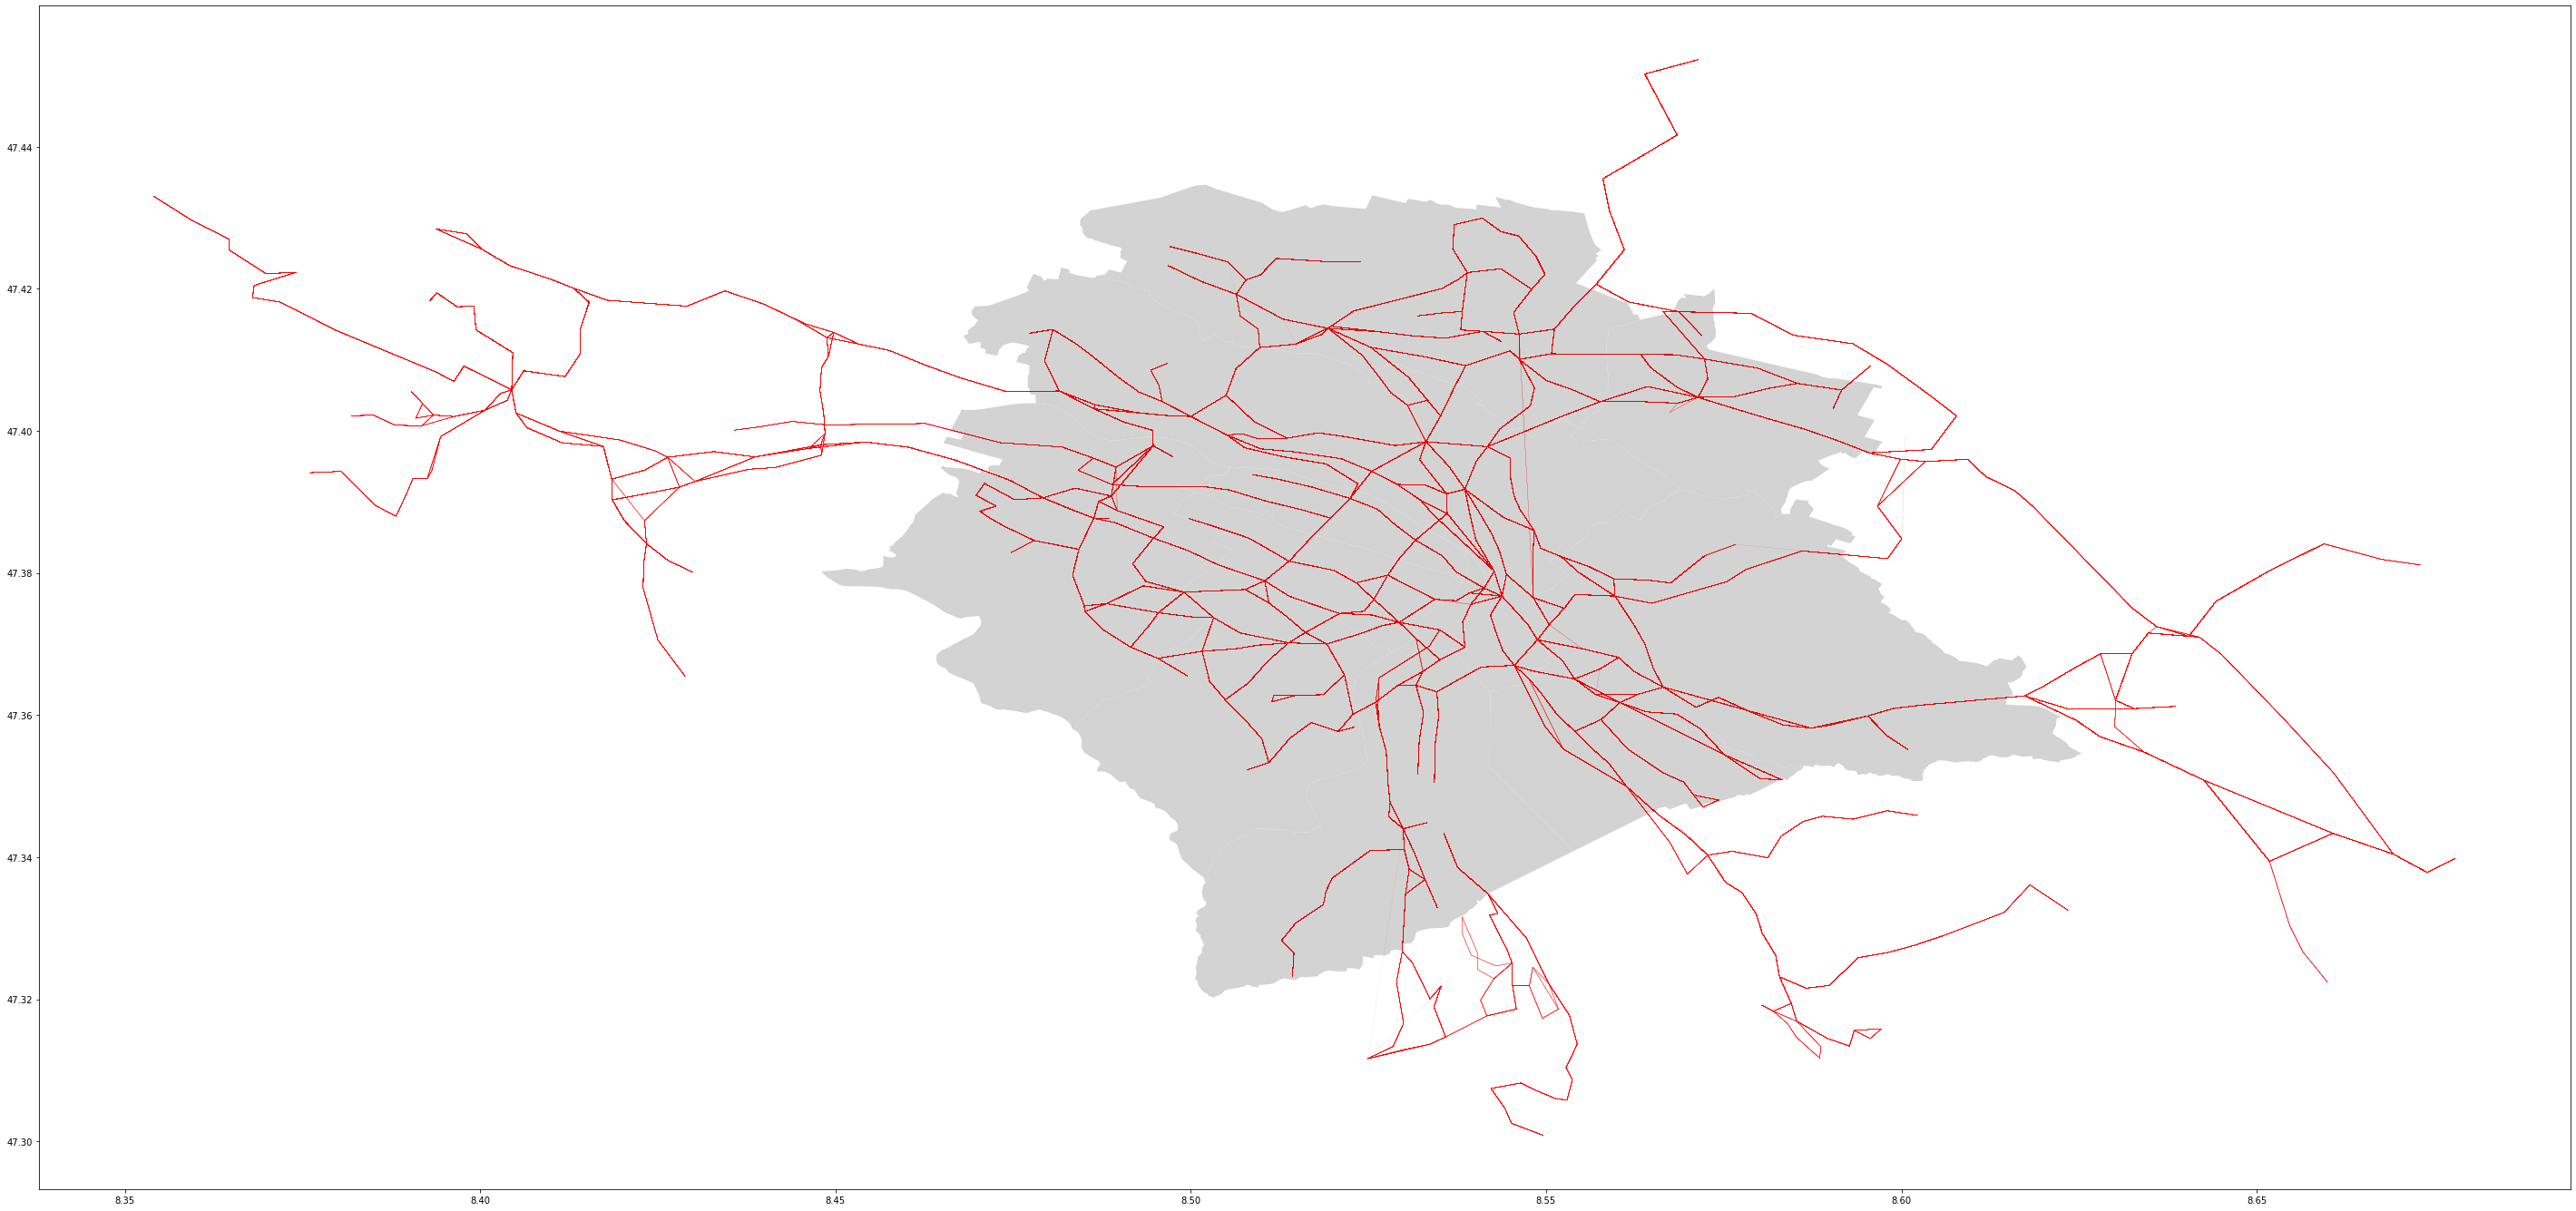

In [38]:
#Aus dem Dataframe einen GeoDataframe bilden
map = gpd.GeoDataFrame(reisende, geometry='lines', )
map.crs = {'init' :'epsg:4326'}
fig, ax = plt.subplots(1, figsize=(50,50))

base = stadtkreise.plot(ax=ax, color='lightgrey')
minx, miny, maxx, maxy = map.total_bounds

map.plot(ax=base, linewidth=0.1, label = '', color='red', alpha=0.5)
#plt.savefig('haltestellen.png',bbox_inches='tight');

type(reisende.lines[0])
type(stadtkreise.geometry[0])

#Bild ausgeben
plt.savefig('linienkarte.png', bbox_inches='tight')